# Analysis of benchmark data

## General remarks

Shell command used to gather data:

```shell
./bin/project2 2 1000 10 400 4000 0.1 && ./bin/project2 3 680 10 400 4000 0.1 && ./bin/project2 4 500 10 400 4000 0.1 && ./bin/project2 5 200 10 400 4000 0.1 && ./bin/project2 6 150 10 400 4000 0.1 && ./bin/project2 7 100 10 400 4000 0.1 && ./bin/project2 8 50 10 400 4000 0.1
```

Benchmarks done on my desktop (WSL) with a Intel i5 Quadcore CPU (with 2x Hyperthreading/SMT). Note that the amount of work done per individual benchmark is not the same.
When more than 4 threads are used, Simultanous Multithreading (SMT, up to 8 threads) is used and the performance drops significantly --> the amount of time to complete one benchmark increases drastically. Thats why I had to reduce the workload drastically to gather sample data for for the different locks.

For similar reasons I only used 10 test iterations



In [91]:
# from csv import reader, DictReader
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
import itertools

In [226]:
def split_csv(file, dest="results"):
    dirname, filename = os.path.split(os.path.abspath(file))
    with open(file, "r") as f:
        line = f.readline()
        i = 0
        newdest = os.path.join(dest, filename.split(".")[0]+f"_{i}.csv")
        new_file = open(newdest, "w")
        new_file.write(line)
        for line in f:
            if line.split(";")[0]=="lock_name":
                new_file.close()
                i += 1
                newdest = os.path.join(dest, filename.split(".")[0]+f"_{i}.csv")
                new_file = open(newdest, "w")
            new_file.write(line)
        new_file.close()


In [ ]:
path = os.getcwd()
print(path)
fins = os.path.join(path, f"results/results/*/*.csv")
dest = os.path.join(path, f"results")
print(fins)
for file in glob.glob(fins):
    print(file)
    split_csv(file, dest)

In [92]:
def strip_cols(df, toStrip=" "):
    """Strips the column names of unwanted characters (such as blanks) and replaces them.
    """
    newcols = []
    for i, col in enumerate(df.columns):
        newcol = col.strip(toStrip)
        newcols.append(newcol)
    df.columns = newcols

In [180]:
type_dict = {"lock_name" : "string"}
for col in ["num_threads","num_turns","num_tests","num_events","workload","cs_workload","mutex_fail_count","fcfs_fail_count","lru_fail_count"]:
    type_dict[col] = "int32"
for col in ["randomness", "thp_runtime_wanc","thp_wanc","anc","thp_runtime_ref","thp_ref","bm_runtime"]:
    type_dict[col] = "float64"

In [211]:
def eval_csv(file, idxResults=8, dsp=False, ret_orig=False, delimiter=";"):
    """
    Reads a csv in our benchmark_format and evaluates it.
    
    Evaluation is done on a per-column-basis (only for results, not parameters).
    The columns [0, idxResult) are considered as parameters, the rest as results.
    Evaluations performed: mean, std, min, max
    """
    df = pd.read_csv(file, delimiter=delimiter)
    param_cols = df.columns[0:idxResults]
    result_cols = df.columns[idxResults:]
    params = df.loc[0,param_cols].to_frame().T
    
    index_to_drop = df[df["lock_name"]=="lock_name"].index
    df = df.drop(index=index_to_drop)
    #display(df[df["lock_name"]=="lock_name"])
    if dsp:
        print("Params:")
        display(params)
        display(df)
    
    new_result_cols = [pair[0]+pair[1] for pair in itertools.product(result_cols, [":mean", ":std", ":min", ":max"])]
    stats_dict = {
        "mean": df[result_cols].mean(),    
        "std": df[result_cols].std(),
        "min": df[result_cols].min(),
        "max": df[result_cols].max()
    }
    stats = pd.DataFrame(columns=new_result_cols)
    for col in stats.columns:
        res, stat = col.split(":")
        stats.loc[0,col] = stats_dict[stat][res]
        
    analysis = pd.concat([params, stats], axis=1)
        
    if dsp:
        print("Stats")
        display(stats)
    
    if ret_orig:
        return analysis, df
    else:
        return analysis
    
def get_cols(file, idxResults=5, dsp=False):
    df_csv = pd.read_csv(file, delimiter=";")
    param_cols = df_csv.columns[0:idxResults]
    result_cols = df_csv.columns[idxResults:]
    return param_cols, result_cols
    
def get_merged_csv(flist, **kwargs):
    return pd.concat([eval_csv(f, **kwargs) for f in flist], axis=0, ignore_index=True), get_cols(flist[0])

In [218]:
# To read only files from a certain lock or lock type --> use regex
# Here for Taubenfeld locks
path = os.getcwd()
lock = "taubenfeld"
fmask = os.path.join(path, f"results/*.csv") # File name mask for filtering
print("File mask:", fmask)

# Evaluate and merge evaluations into 1 DataFrame
df, (param_cols, result_cols) = get_merged_csv(glob.glob(fmask), delimiter=";", dsp=False)
df = df.sort_values(["lock_name", "workload", "num_threads"])

File mask: /Users/peterholzner/Code/amp/project/cluster/results/*.csv


In [220]:
display(df["lock_name"].unique())
display(df[df["lock_name"]=="Aravind_fix"]["num_threads"].unique())
df

array(['Aravind_fix', 'Jayanti_BT', 'Lamport_Lecture_atomic',
       'Reference-Lock', 'Taubenfeld_Paper_1_atomic'], dtype=object)

array([2, 3, 4, 8, 16, 32, 64], dtype=object)

,lock_name,num_threads,num_turns,num_tests,num_events,workload,cs_workload,randomness,mutex_fail_count:mean,mutex_fail_count:std,...,thp_runtime_ref:min,thp_runtime_ref:max,thp_ref:mean,thp_ref:std,thp_ref:min,thp_ref:max,bm_runtime:mean,bm_runtime:std,bm_runtime:min,bm_runtime:max
61,Aravind_fix,2,5000,30,40000,0,0,0.4,0,0,...,0.0173315,0.0215232,549674,24473.4,464614,576984,1.25263,2.25841e-16,1.25263,1.25263
58,Aravind_fix,3,5000,30,60000,0,0,0.4,0,0,...,0.0183259,0.021656,773244,25496,692650,818515,1.30706,0,1.30706,1.30706
48,Aravind_fix,4,5000,30,80000,0,0,0.4,0,0,...,0.0546894,0.0833475,301660,45150.4,239959,365701,4.2532,3.61345e-15,4.2532,4.2532
51,Aravind_fix,8,5000,30,160000,0,0,0.4,0,0,...,0.191632,0.203972,203543,3270.75,196105,208734,13.5021,3.61345e-15,13.5021,13.5021
69,Aravind_fix,16,5000,30,320000,0,0,0.4,0,0,...,0.556109,0.582075,141420,1255.77,137439,143857,40.7629,3.61345e-14,40.7629,40.7629
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28,Taubenfeld_Paper_1_atomic,4,1000,30,16000,1000,100,0.4,0,0,...,0.0159112,0.0238365,188537,20579.6,167810,251396,1.58074,6.77522e-16,1.58074,1.58074
25,Taubenfeld_Paper_1_atomic,8,1000,30,32000,1000,100,0.4,0,0,...,0.0349694,0.0380365,221878,4062.3,210324,228771,2.66928,0,2.66928,2.66928
36,Taubenfeld_Paper_1_atomic,16,1000,30,64000,1000,100,0.4,0,0,...,0.0765788,0.0854724,194655,4624.82,187195,208935,6.37279,9.03362e-16,6.37279,6.37279
35,Taubenfeld_Paper_1_atomic,32,1000,30,128000,1000,100,0.4,0,0,...,0.177808,0.189751,175265,3002.69,168642,179970,19.3319,7.2269e-15,19.3319,19.3319


In [12]:
param_cols, result_cols

(Index(['lock_name', 'num_threads', 'num_turns', 'num_tests', 'num_events'], dtype='object'),
 Index(['mutex_fail_count', 'fcfs_fail_count', 'lru_fail_count',
        'thp_runtime_wanc', 'thp_wanc', 'anc', 'thp_runtime_ref', 'thp_ref',
        'bm_runtime'],
       dtype='object'))

In [221]:
all_locks = df["lock_name"].unique()
print("# of different locks/versions:", all_locks.shape[0])
all_locks

# of different locks/versions: 5


array(['Aravind_fix', 'Jayanti_BT', 'Lamport_Lecture_atomic',
       'Reference-Lock', 'Taubenfeld_Paper_1_atomic'], dtype=object)

In [225]:
good_locks = ['Aravind_fix', 'Jayanti_BT', 'Lamport_Lecture_atomic', 'Reference-Lock', 'Taubenfeld_Paper_1_atomic']

# Evaluation

In [227]:
import matplotlib as mpl

#mpl.style.use("classic")
mpl.style.use("seaborn")

In [333]:
# Line Style rotation used
lstyle_rotation = ['-', '--', '-.', ':']
# Some factors to control how the error bars are calculated based on the std
powFact = 1
multFact = 1
axfontsize = 14

def plot_col(df, x_col="num_threads", y_col="mutex_fail_count", locksToPlot=good_locks,
             title=None, norm=False, errBarMode="sem", paramPos=(0.35, 0.85), plotScale="lin", **kwargs):
    """A convenience function for plotting.
    
    -) xcol, ycol are the names of the columns to use for plotting. The mean is 
        plotted for ycol with an errorbar based on std (standard deviation)
    """
    assert errBarMode in ["std", "sem", "minmax", "None"], "Error mode unknown"
    
    # Filtering locksToPlot
    if not title:
        title = y_col + " over " + x_col
        
    if isinstance(locksToPlot, str):
        locks = [l for l in df["lock_name"].unique() if locksToPlot in l]
    elif isinstance(locksToPlot, np.ndarray):
        locks = locksToPlot
    elif not locksToPlot:
        locks = df["lock_name"].unique()
    else:
        locks = locksToPlot
        
        
    print("Plotting locks:", locks)
    fig, ax = plt.subplots(figsize=(14,8))

    for i, lock in enumerate(locks):
        lstyle = lstyle_rotation[i%len(lstyle_rotation)]
        x, y = df[df["lock_name"]==lock][x_col],\
                     df[df["lock_name"]==lock][y_col+":mean"]
        if errBarMode=="std":
            yerr = multFact * np.power(df[df["lock_name"]==lock][y_col+":std"], powFact)
        elif errBarMode=="sem":
            num_tests = df.loc[0,"num_tests"]
            yerr = multFact * np.power(df[df["lock_name"]==lock][y_col+":std"], powFact) / np.sqrt(num_tests)
        elif errBarMode=="minmax":
            yerr = multFact * np.power( (df[df["lock_name"]==lock][y_col+":min"], df[df["lock_name"]==lock][y_col+":max"]) , powFact)
        elif errBarMode=="None":
            yerr = None
            
        if norm:
            y /= df[df["lock_name"]==lock]["num_events"]*4
            yerr /= df[df["lock_name"]==lock]["num_events"]*4
        plt.errorbar(x, y, yerr=yerr, label=lock, marker="o", linewidth=2, ls=lstyle, capsize=5, capthick=2, **kwargs)
        #sns.pointplot(x="time", y="total_bill", dodge=True,)
    if plotScale=="log":
        plt.yscale("log")
    text = "Parameters:\n" + df.loc[0,param_cols[2:-1]].to_string() + f"\nerror                 {errBarMode}"
    #text = "a"
    plt.figtext(*paramPos, text, fontsize=14, verticalalignment='top', bbox={"facecolor": "white", "edgecolor": "green","alpha": 0.7})
    plt.grid(True)
    plt.xlabel(x_col, fontsize=axfontsize)
    plt.ylabel(y_col, fontsize=axfontsize)
    plt.legend(fontsize=axfontsize)
    xticks = list(df["num_threads"].unique()) #np.arange(x.min(), x.max()+1, 1)
    plt.xticks(ticks=xticks, fontsize=axfontsize);
    plt.yticks(fontsize=axfontsize)
    plt.suptitle(title, fontsize=28, fontweight="bold");

In [309]:
df_100 = df[df["workload"]==100].reset_index(drop=True)
df_1000 = df[df["workload"]==100].reset_index(drop=True)
df_0 = df[df["workload"]==0].reset_index(drop=True)
df_0.head()

,lock_name,num_threads,num_turns,num_tests,num_events,workload,cs_workload,randomness,mutex_fail_count:mean,mutex_fail_count:std,...,thp_runtime_ref:min,thp_runtime_ref:max,thp_ref:mean,thp_ref:std,thp_ref:min,thp_ref:max,bm_runtime:mean,bm_runtime:std,bm_runtime:min,bm_runtime:max
0,Aravind_fix,2,5000,30,40000,0,0,0.4,0,0,...,0.0173315,0.0215232,549674,24473.4,464614,576984,1.25263,2.25841e-16,1.25263,1.25263
1,Aravind_fix,3,5000,30,60000,0,0,0.4,0,0,...,0.0183259,0.021656,773244,25496,692650,818515,1.30706,0,1.30706,1.30706
2,Aravind_fix,4,5000,30,80000,0,0,0.4,0,0,...,0.0546894,0.0833475,301660,45150.4,239959,365701,4.2532,3.61345e-15,4.2532,4.2532
3,Aravind_fix,8,5000,30,160000,0,0,0.4,0,0,...,0.191632,0.203972,203543,3270.75,196105,208734,13.5021,3.61345e-15,13.5021,13.5021
4,Aravind_fix,16,5000,30,320000,0,0,0.4,0,0,...,0.556109,0.582075,141420,1255.77,137439,143857,40.7629,3.61345e-14,40.7629,40.7629


In [335]:
savefigs_global = True

# Runtime (of throughput test)

Plotting locks: ['Aravind_fix', 'Jayanti_BT', 'Lamport_Lecture_atomic', 'Reference-Lock', 'Taubenfeld_Paper_1_atomic']


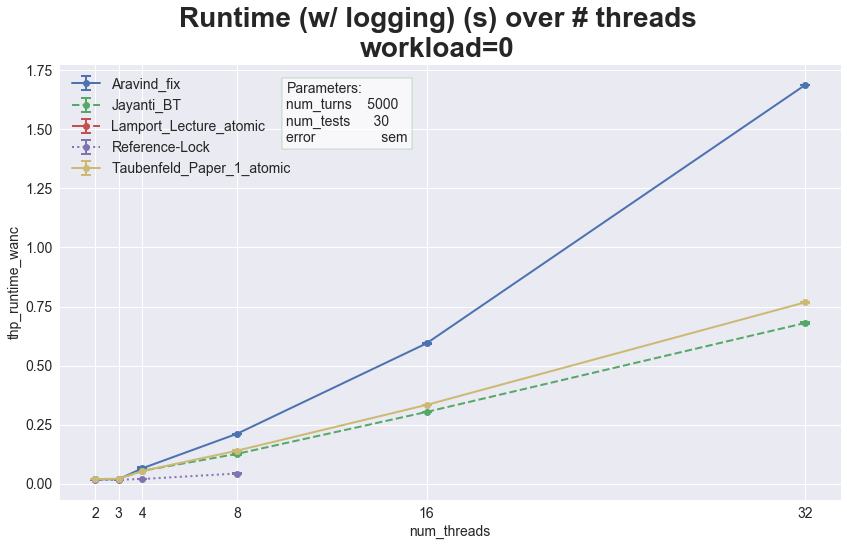

Plotting locks: ['Aravind_fix', 'Jayanti_BT', 'Lamport_Lecture_atomic', 'Reference-Lock', 'Taubenfeld_Paper_1_atomic']


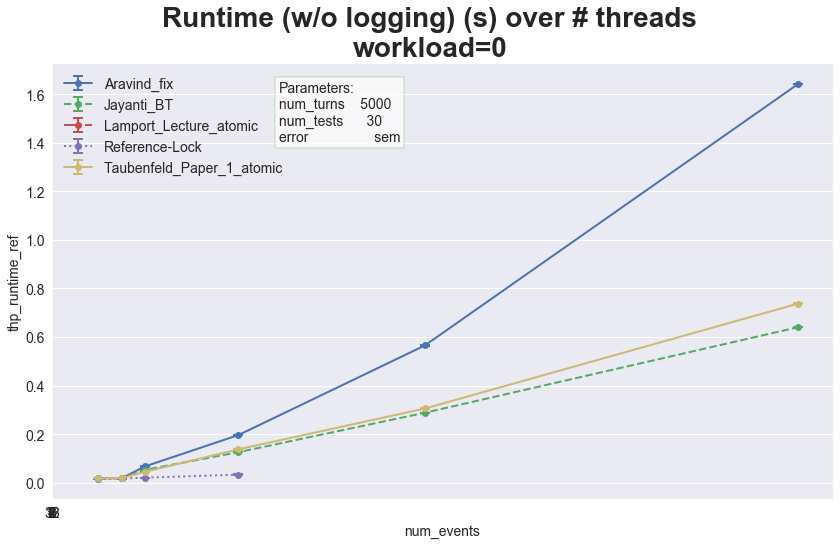

In [336]:
wl = 0
plot_col(df_0, x_col="num_threads", y_col="thp_runtime_wanc", title=f"Runtime (w/ logging) (s) over # threads\nworkload={wl}", norm=False)
if savefigs_global:
    plt.savefig(f"plots/runtime_wl{wl}.png")
plt.show()
plot_col(df_0, x_col="num_events", y_col="thp_runtime_ref", title=f"Runtime (w/o logging) (s) over # threads\nworkload={wl}", norm=False)
if savefigs_global:
    plt.savefig(f"plots/runtime_ref_wl{wl}.png")
plt.show()

Plotting locks: ['Aravind_fix', 'Jayanti_BT', 'Lamport_Lecture_atomic', 'Reference-Lock', 'Taubenfeld_Paper_1_atomic']


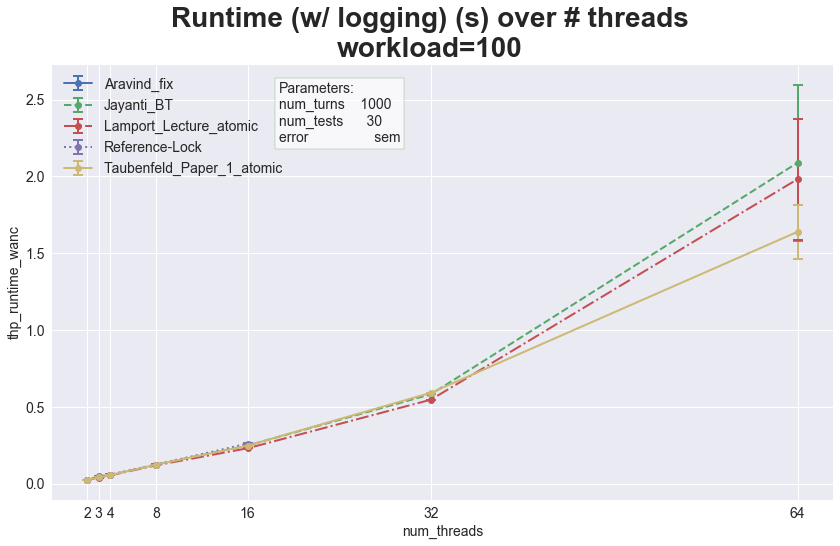

Plotting locks: ['Aravind_fix', 'Jayanti_BT', 'Lamport_Lecture_atomic', 'Reference-Lock', 'Taubenfeld_Paper_1_atomic']


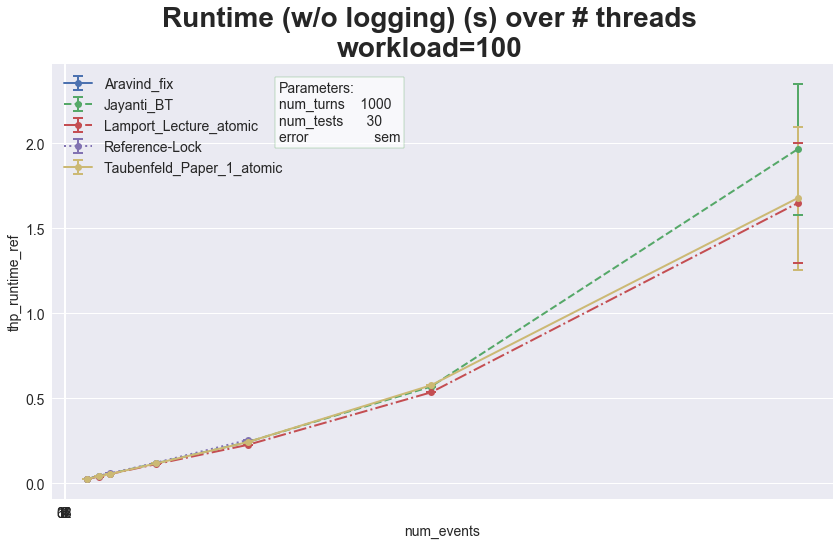

In [337]:
wl = 100
plot_col(df_100, x_col="num_threads", y_col="thp_runtime_wanc", title=f"Runtime (w/ logging) (s) over # threads\nworkload={wl}", norm=False)
if savefigs_global:
    plt.savefig(f"plots/runtime_wl{wl}.png")
plt.show()
plot_col(df_100, x_col="num_events", y_col="thp_runtime_ref", title=f"Runtime (w/o logging) (s) over # threads\nworkload={wl}", norm=False)
if savefigs_global:
    plt.savefig(f"plots/runtime_ref_wl{wl}.png")
plt.show()

Plotting locks: ['Aravind_fix', 'Jayanti_BT', 'Lamport_Lecture_atomic', 'Reference-Lock', 'Taubenfeld_Paper_1_atomic']


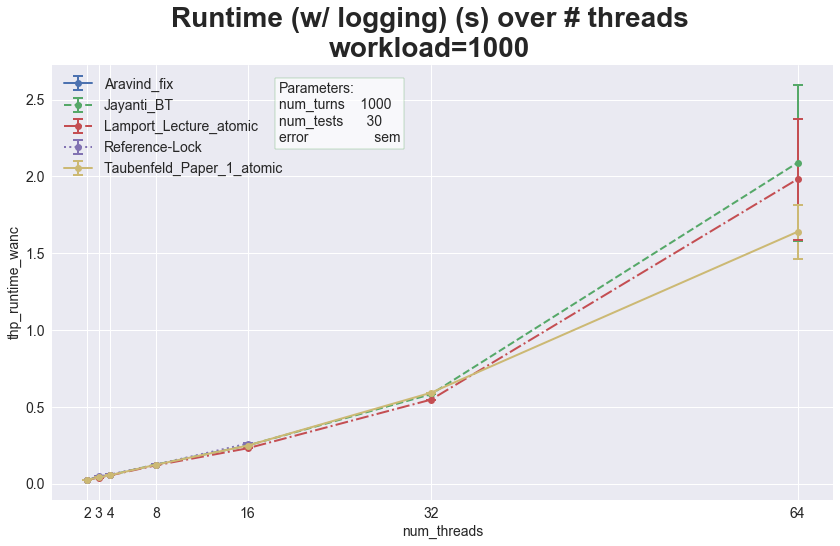

Plotting locks: ['Aravind_fix', 'Jayanti_BT', 'Lamport_Lecture_atomic', 'Reference-Lock', 'Taubenfeld_Paper_1_atomic']


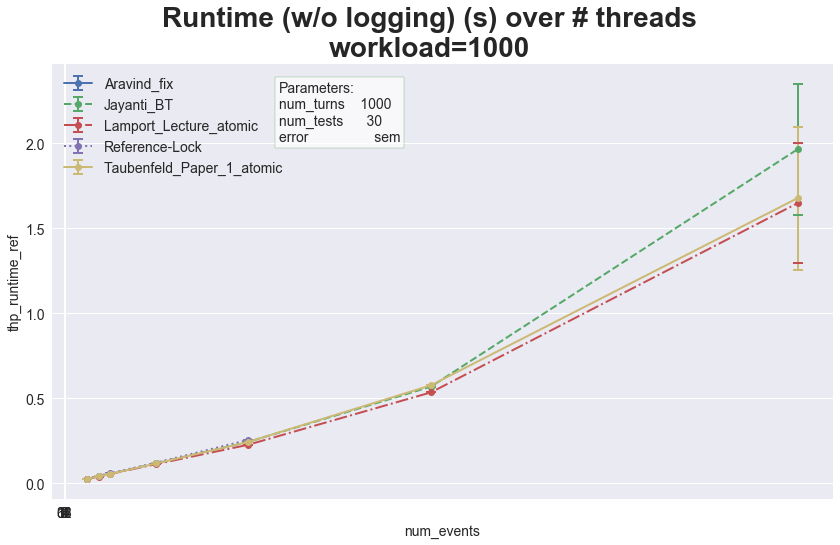

In [338]:
wl = 1000
plot_col(df_1000, x_col="num_threads", y_col="thp_runtime_wanc", title=f"Runtime (w/ logging) (s) over # threads\nworkload={wl}", norm=False)
if savefigs_global:
    plt.savefig(f"plots/runtime_wl{wl}.png")
plt.show()
plot_col(df_1000, x_col="num_events", y_col="thp_runtime_ref", title=f"Runtime (w/o logging) (s) over # threads\nworkload={wl}", norm=False)
if savefigs_global:
    plt.savefig(f"plots/runtime_ref_wl{wl}.png")
plt.show()

# Throughput

Plotting locks: ['Aravind_fix', 'Jayanti_BT', 'Lamport_Lecture_atomic', 'Reference-Lock', 'Taubenfeld_Paper_1_atomic']


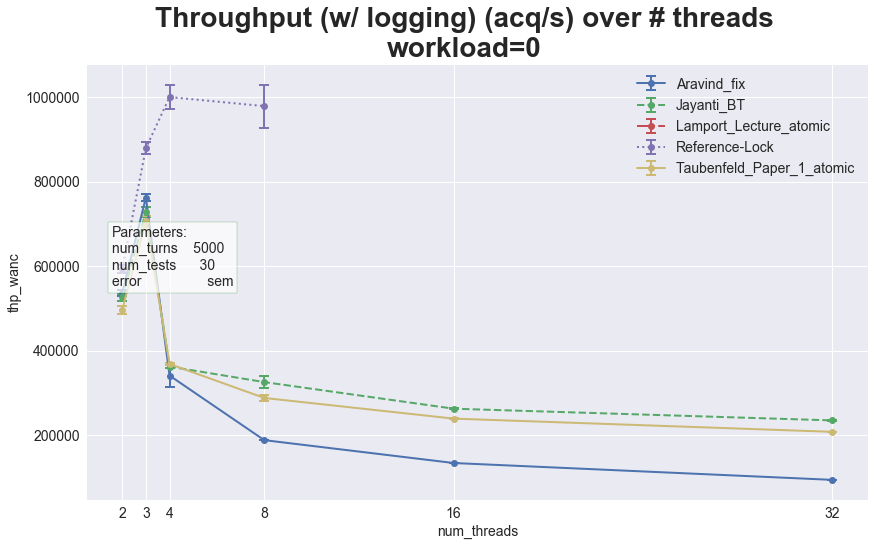

Plotting locks: ['Aravind_fix', 'Jayanti_BT', 'Lamport_Lecture_atomic', 'Reference-Lock', 'Taubenfeld_Paper_1_atomic']


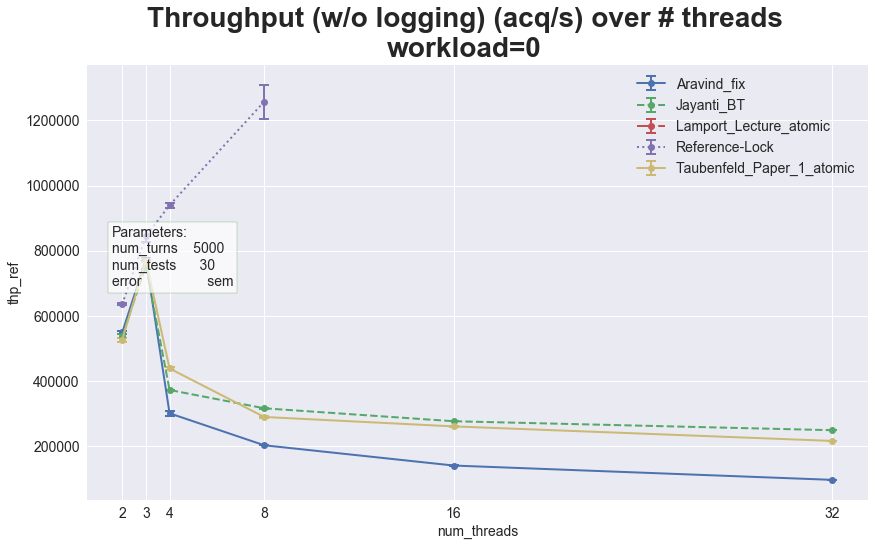

In [339]:
wl = 0
plot_col(df_0, x_col="num_threads", y_col="thp_wanc", title=f"Throughput (w/ logging) (acq/s) over # threads\nworkload={wl}", norm=False, paramPos=(0.15, 0.6))
if savefigs_global:
    plt.savefig(f"plots/throughput_wl{wl}.png")
plt.show()
plot_col(df_0, x_col="num_threads", y_col="thp_ref", title=f"Throughput (w/o logging) (acq/s) over # threads\nworkload={wl}", norm=False, paramPos=(0.15, 0.6))
if savefigs_global:
    plt.savefig(f"plots/throughput_ref_wl{wl}.png")
plt.show()

Plotting locks: ['Aravind_fix', 'Jayanti_BT', 'Lamport_Lecture_atomic', 'Reference-Lock', 'Taubenfeld_Paper_1_atomic']


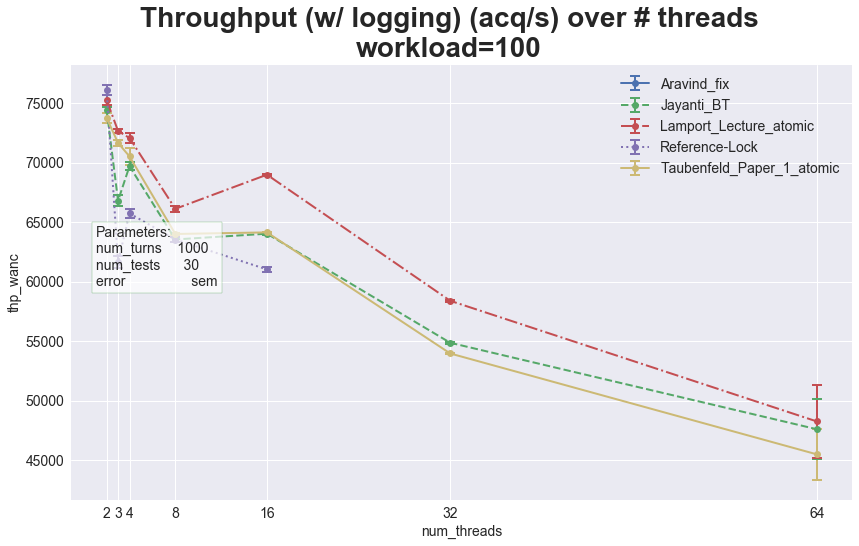

Plotting locks: ['Aravind_fix', 'Jayanti_BT', 'Lamport_Lecture_atomic', 'Reference-Lock', 'Taubenfeld_Paper_1_atomic']


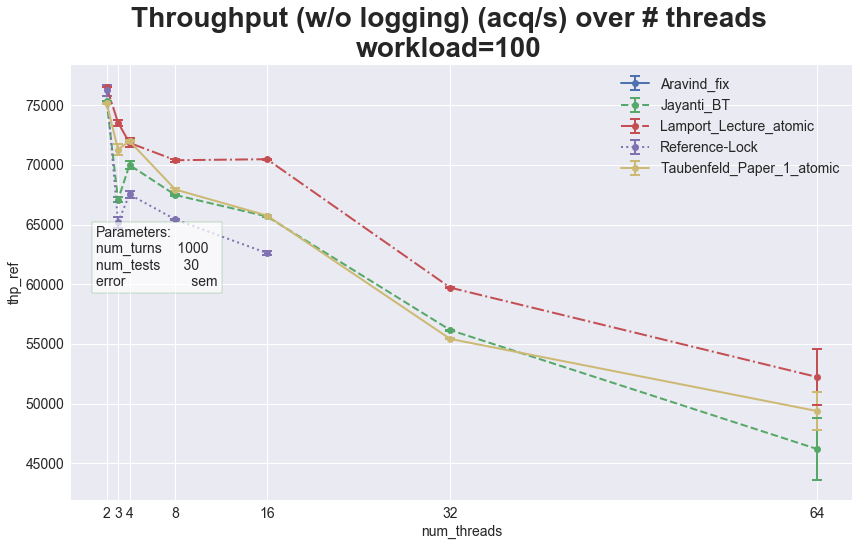

In [340]:
wl = 100
plot_col(df_100, x_col="num_threads", y_col="thp_wanc", title=f"Throughput (w/ logging) (acq/s) over # threads\nworkload={wl}", norm=False, paramPos=(0.15, 0.6))
if savefigs_global:
    plt.savefig(f"plots/throughput_wl{wl}.png")
plt.show()
plot_col(df_100, x_col="num_threads", y_col="thp_ref", title=f"Throughput (w/o logging) (acq/s) over # threads\nworkload={wl}", norm=False, paramPos=(0.15, 0.6))
if savefigs_global:
    plt.savefig(f"plots/throughput_ref_wl{wl}.png")
plt.show()

Plotting locks: ['Aravind_fix', 'Jayanti_BT', 'Lamport_Lecture_atomic', 'Reference-Lock', 'Taubenfeld_Paper_1_atomic']


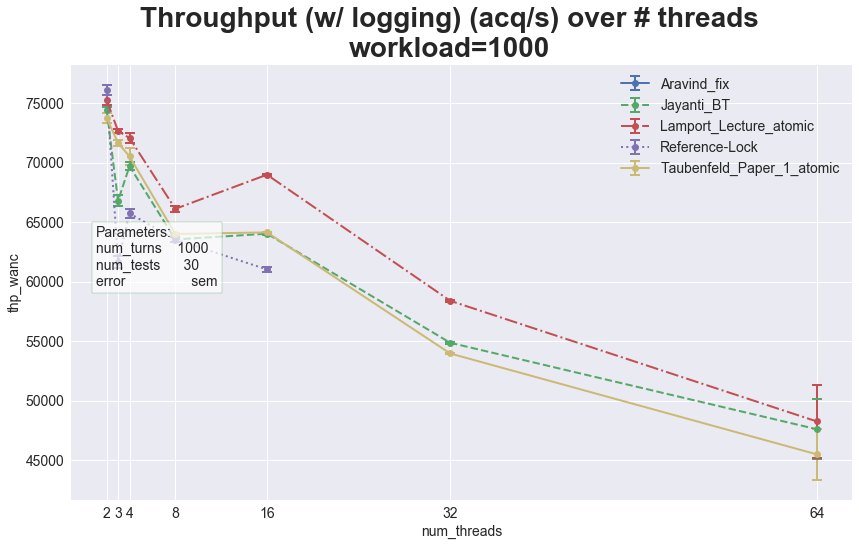

Plotting locks: ['Aravind_fix', 'Jayanti_BT', 'Lamport_Lecture_atomic', 'Reference-Lock', 'Taubenfeld_Paper_1_atomic']


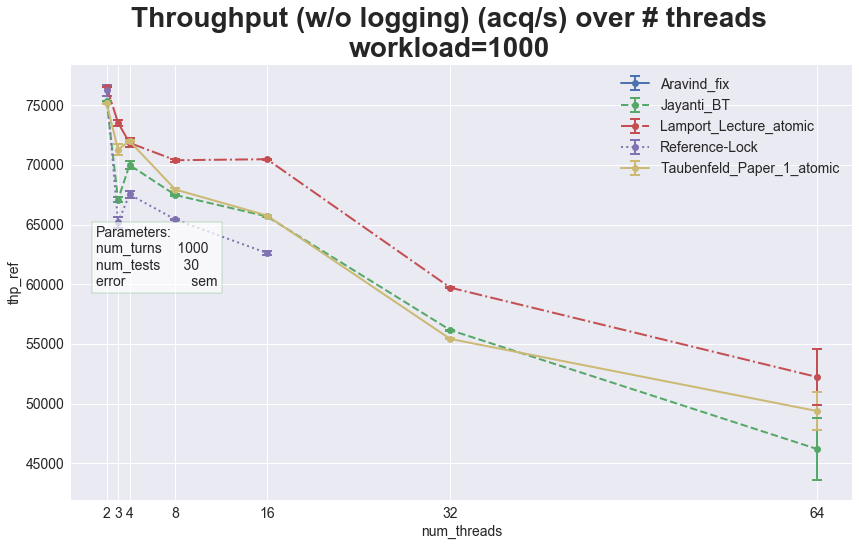

In [341]:
wl = 1000
plot_col(df_1000, x_col="num_threads", y_col="thp_wanc", title=f"Throughput (w/ logging) (acq/s) over # threads\nworkload={wl}", norm=False, paramPos=(0.15, 0.6))
if savefigs_global:
    plt.savefig(f"plots/throughput_wl{wl}.png")
plt.show()
plot_col(df_1000, x_col="num_threads", y_col="thp_ref", title=f"Throughput (w/o logging) (acq/s) over # threads\nworkload={wl}", norm=False, paramPos=(0.15, 0.6))
if savefigs_global:
    plt.savefig(f"plots/throughput_ref_wl{wl}.png")
plt.show()

Plotting locks: ['Aravind_fix', 'Jayanti_BT', 'Lamport_Lecture_atomic', 'Reference-Lock', 'Taubenfeld_Paper_1_atomic']


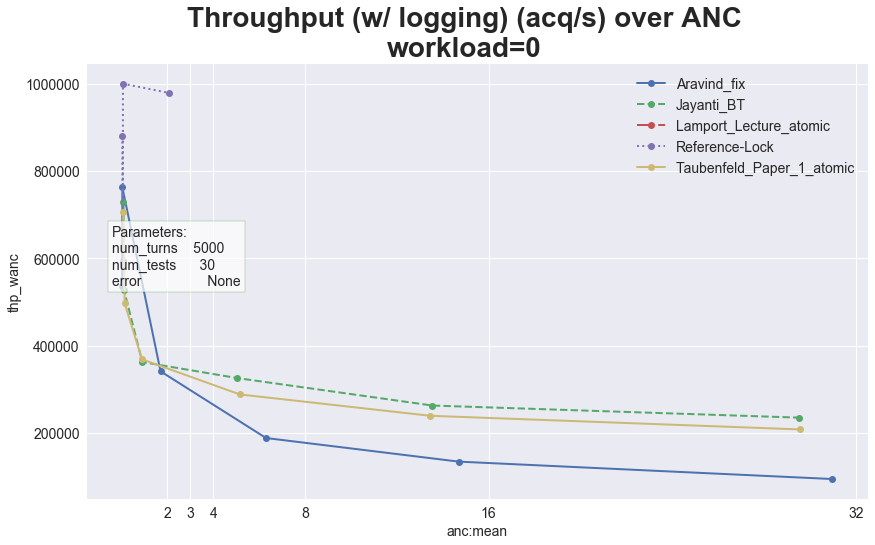

In [342]:
wl = 0
plot_col(df_0.sort_values(["lock_name", "anc:mean"]), x_col="anc:mean", y_col="thp_wanc", title=f"Throughput (w/ logging) (acq/s) over ANC\nworkload={wl}", 
         norm=False, paramPos=(0.15, 0.6), errBarMode="None")
if savefigs_global:
    plt.savefig(f"plots/throughput_over_anc_wl{wl}.png")
plt.show()

Plotting locks: ['Aravind_fix', 'Jayanti_BT', 'Lamport_Lecture_atomic', 'Reference-Lock', 'Taubenfeld_Paper_1_atomic']


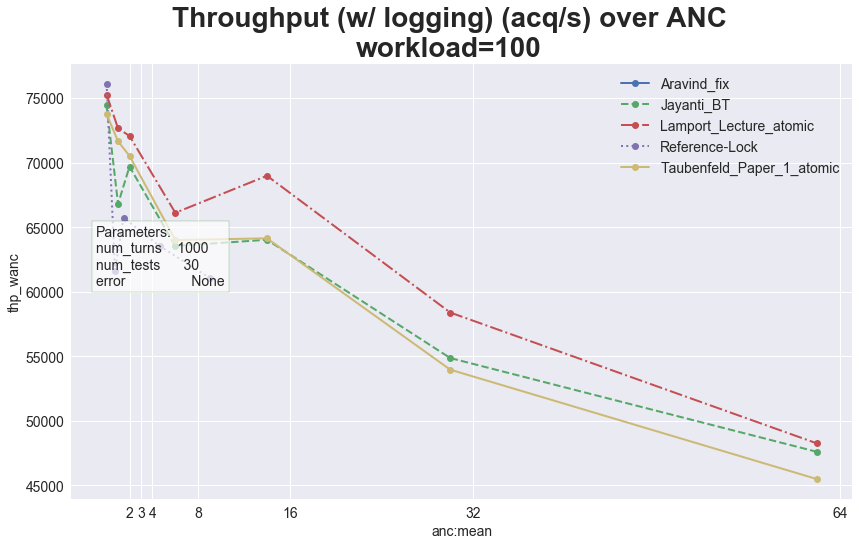

In [343]:
wl = 100
plot_col(df_100.sort_values(["lock_name", "anc:mean"]), x_col="anc:mean", y_col="thp_wanc", title=f"Throughput (w/ logging) (acq/s) over ANC\nworkload={wl}", 
         norm=False, paramPos=(0.15, 0.6), errBarMode="None")
if savefigs_global:
    plt.savefig(f"plots/throughput_over_anc_wl{wl}.png")
plt.show()

Plotting locks: ['Aravind_fix', 'Jayanti_BT', 'Lamport_Lecture_atomic', 'Reference-Lock', 'Taubenfeld_Paper_1_atomic']


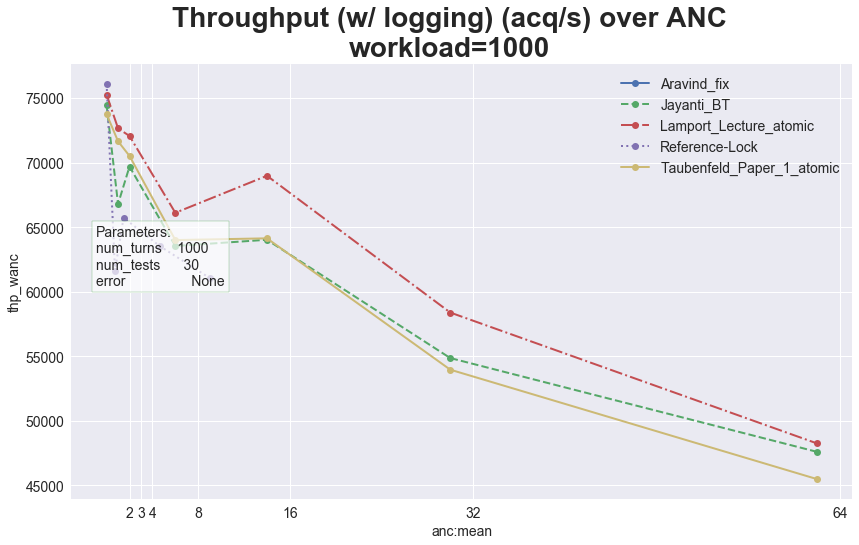

In [344]:
wl = 1000
plot_col(df_1000.sort_values(["lock_name", "anc:mean"]), x_col="anc:mean", y_col="thp_wanc", title=f"Throughput (w/ logging) (acq/s) over ANC\nworkload={wl}", 
         norm=False, paramPos=(0.15, 0.6), errBarMode="None")
if savefigs_global:
    plt.savefig(f"plots/throughput_over_anc_wl{wl}.png")
plt.show()

Plotting locks: ['Aravind_fix', 'Jayanti_BT', 'Lamport_Lecture_atomic', 'Reference-Lock', 'Taubenfeld_Paper_1_atomic']


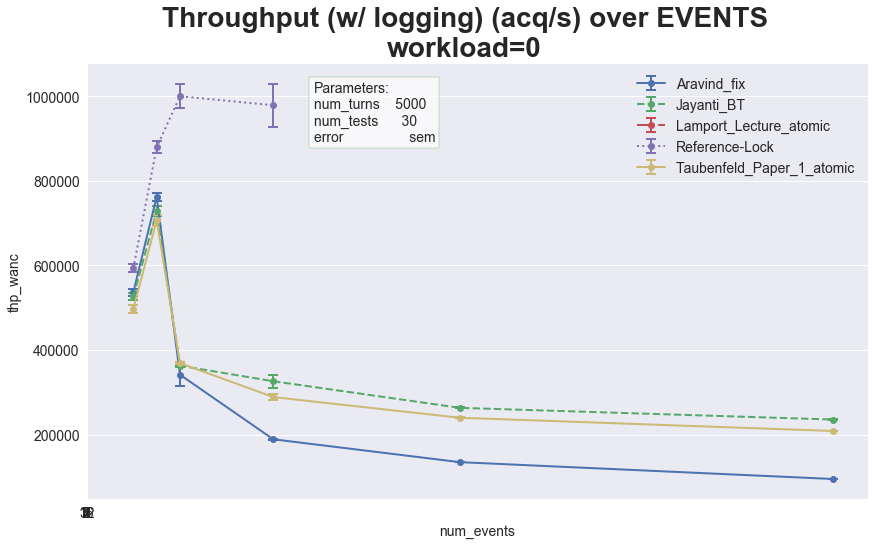

In [345]:
wl = 0
plot_col(df_0.sort_values(["lock_name", "num_events",]), x_col="num_events", y_col="thp_wanc", title=f"Throughput (w/ logging) (acq/s) over EVENTS\nworkload={wl}")#, 
         #norm=False, paramPos=(0.15, 0.6), locksToPlot=filtered2)
if savefigs_global:
    plt.savefig(f"plots/throughput_over_events_wl{wl}.png")
plt.show()

Plotting locks: ['Aravind_fix', 'Jayanti_BT', 'Lamport_Lecture_atomic', 'Reference-Lock', 'Taubenfeld_Paper_1_atomic']


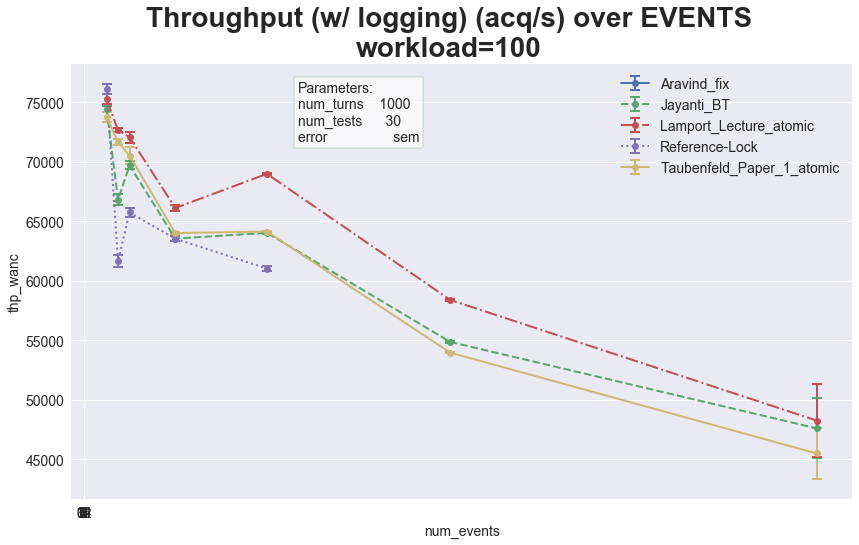

In [346]:
wl = 100
plot_col(df_100.sort_values(["lock_name", "num_events",]), x_col="num_events", y_col="thp_wanc", title=f"Throughput (w/ logging) (acq/s) over EVENTS\nworkload={wl}")#, 
         #norm=False, paramPos=(0.15, 0.6), locksToPlot=filtered2)
if savefigs_global:
    plt.savefig(f"plots/throughput_over_events_wl{wl}.png")
plt.show()

Plotting locks: ['Aravind_fix', 'Jayanti_BT', 'Lamport_Lecture_atomic', 'Reference-Lock', 'Taubenfeld_Paper_1_atomic']


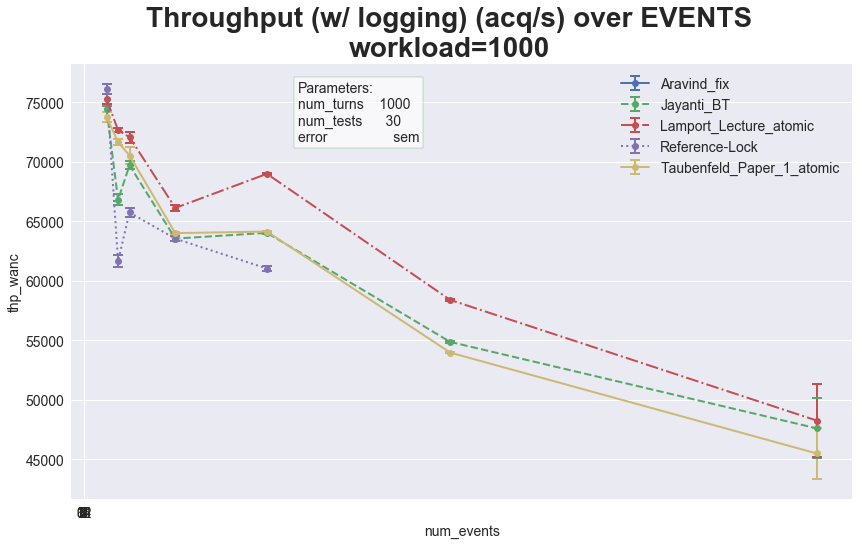

In [347]:
wl = 1000
plot_col(df_1000.sort_values(["lock_name", "num_events",]), x_col="num_events", y_col="thp_wanc", title=f"Throughput (w/ logging) (acq/s) over EVENTS\nworkload={wl}")#, 
         #norm=False, paramPos=(0.15, 0.6), locksToPlot=filtered2)
if savefigs_global:
    plt.savefig(f"plots/throughput_over_events_wl{wl}.png")
plt.show()

# Average number of contenders

Plotting locks: ['Aravind_fix', 'Jayanti_BT', 'Lamport_Lecture_atomic', 'Reference-Lock', 'Taubenfeld_Paper_1_atomic']


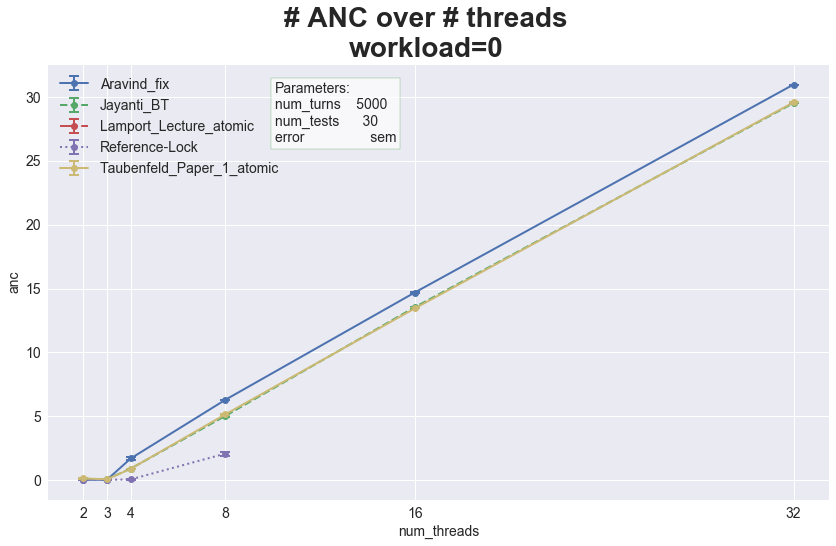

In [348]:
wl = 0
plot_col(df_0, x_col="num_threads", y_col="anc", title=f"# ANC over # threads\nworkload={wl}", norm=False)
if savefigs_global:
    plt.savefig(f"plots/anc_wl{wl}.png")
plt.show()

In [349]:
startidx = 29
#df_100.iloc[:,startidx:startidx+8]
display(df_100.iloc[:,startidx:startidx+4])
df_100.iloc[:,0:3]

,anc:std,anc:min,anc:max,thp_runtime_ref:mean
0,0.000203419,0.0005,0.001,0.026542
1,0.000699718,0.996333,1.00033,0.0447305
2,0.000472217,1.99775,1.99975,0.0571955
3,0.000484741,5.99613,5.99787,0.118563
4,0.000382686,13.9922,13.9937,0.243596
5,0.000193129,29.9848,29.9856,0.569764
6,0.00299341,61.9608,61.9797,1.96571
7,0.000224888,0,0.001,0.0261306
8,0.000321404,0.999,1.001,0.0408076
9,0.000242858,1.99925,2.00075,0.0557182


,lock_name,num_threads,num_turns
0,Jayanti_BT,2,1000
1,Jayanti_BT,3,1000
2,Jayanti_BT,4,1000
3,Jayanti_BT,8,1000
4,Jayanti_BT,16,1000
5,Jayanti_BT,32,1000
6,Jayanti_BT,64,1000
7,Lamport_Lecture_atomic,2,1000
8,Lamport_Lecture_atomic,3,1000
9,Lamport_Lecture_atomic,4,1000


Plotting locks: ['Aravind_fix', 'Jayanti_BT', 'Lamport_Lecture_atomic', 'Reference-Lock', 'Taubenfeld_Paper_1_atomic']


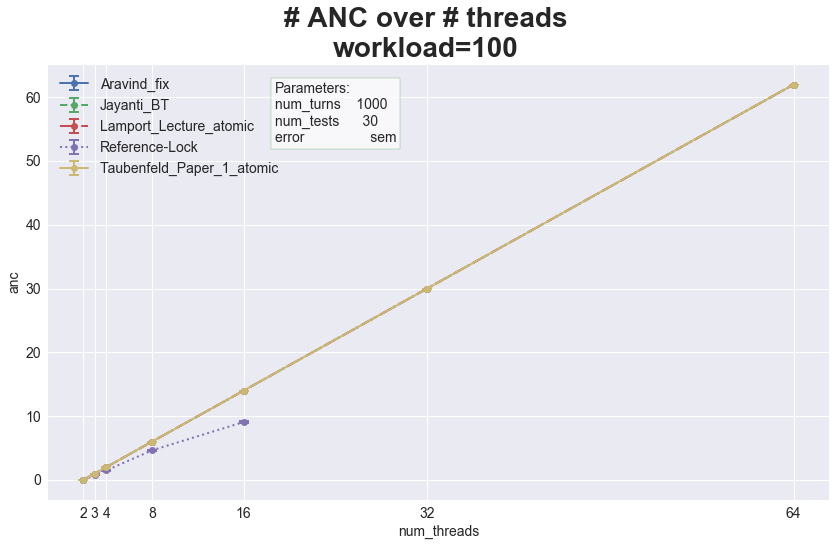

In [350]:
wl = 100
plot_col(df_100, x_col="num_threads", y_col="anc", title=f"# ANC over # threads\nworkload={wl}", norm=False, errBarMode="sem")
if savefigs_global:
    plt.savefig(f"plots/anc_wl{wl}.png")
plt.show()

Plotting locks: ['Aravind_fix', 'Jayanti_BT', 'Lamport_Lecture_atomic', 'Reference-Lock', 'Taubenfeld_Paper_1_atomic']


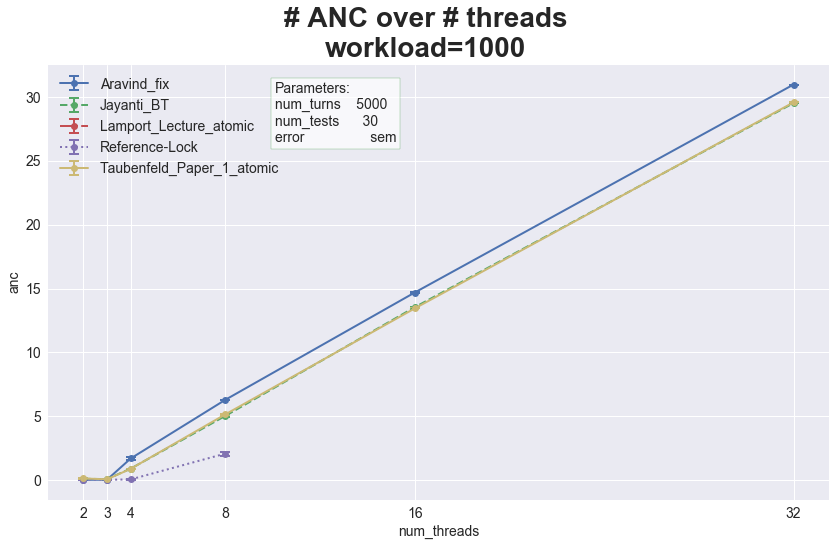

In [351]:
wl = 1000
plot_col(df_0, x_col="num_threads", y_col="anc", title=f"# ANC over # threads\nworkload={wl}", norm=False)
if savefigs_global:
    plt.savefig(f"plots/anc_wl{wl}.png")
plt.show()

# Mutex failures over nthreads

Plotting locks: ['Aravind_fix', 'Jayanti_BT', 'Lamport_Lecture_atomic', 'Reference-Lock', 'Taubenfeld_Paper_1_atomic']


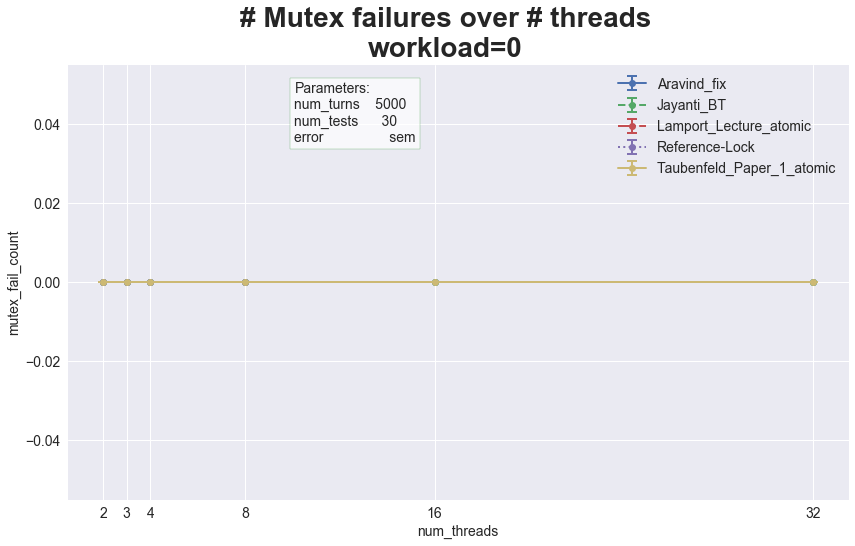

In [352]:
wl = 0
plot_col(df_0, x_col="num_threads", y_col="mutex_fail_count", title=f"# Mutex failures over # threads\nworkload={wl}", norm=False)
if savefigs_global:
    plt.savefig(f"plots/mutex_fails_wl{wl}.png")
plt.show()

# FCFS failures over nthreads

Plotting locks: ['Aravind_fix', 'Jayanti_BT', 'Lamport_Lecture_atomic', 'Reference-Lock', 'Taubenfeld_Paper_1_atomic']


ValueError: Format 'png_wl0' is not supported (supported formats: eps, pdf, pgf, png, ps, raw, rgba, svg, svgz)

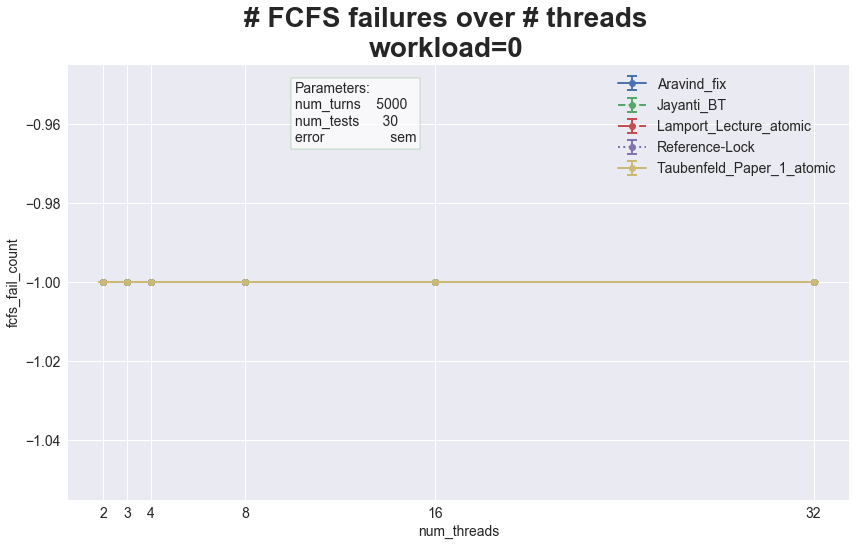

In [353]:
wl = 0
plot_col(df_0, x_col="num_threads", y_col="fcfs_fail_count", title=f"# FCFS failures over # threads\nworkload={wl}", norm=False)
if savefigs_global:
    plt.savefig(f"plots/fcfs_fails.png_wl{wl}")
plt.show()

# LRU failures over nthreads

Plotting locks: ['Aravind_fix', 'Jayanti_BT', 'Lamport_Lecture_atomic', 'Reference-Lock', 'Taubenfeld_Paper_1_atomic']


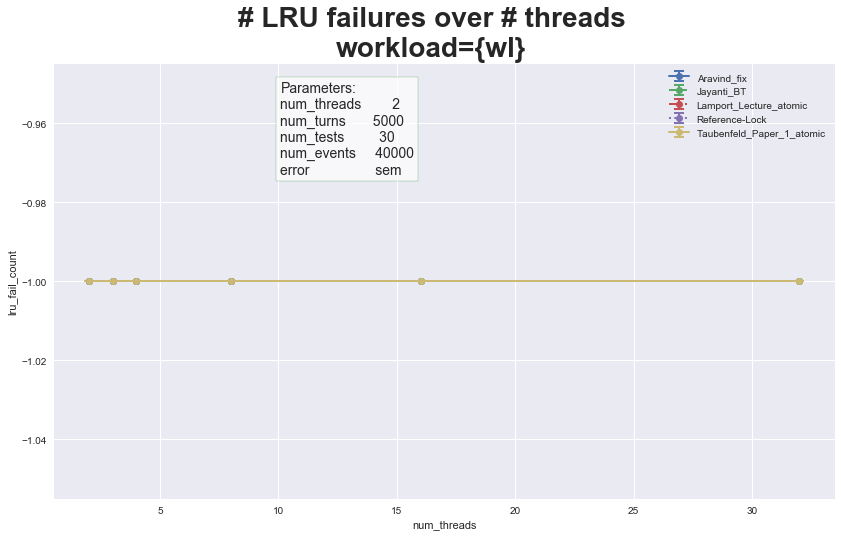

Plotting locks: ['Aravind_fix', 'Jayanti_BT', 'Lamport_Lecture_atomic', 'Reference-Lock', 'Taubenfeld_Paper_1_atomic']


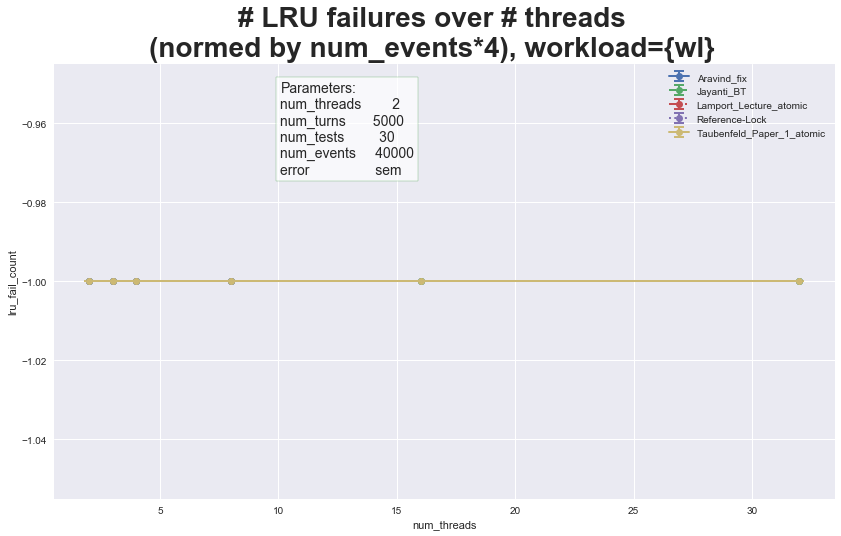

In [250]:
wl = 0
plot_col(df_0, x_col="num_threads", y_col="lru_fail_count", title=f"# LRU failures over # threads\nworkload={wl}",\
         norm=False)
if savefigs_global:
    plt.savefig(f"plots/lru_fails_wl{wl}.png")
plt.show()
plot_col(df_0, x_col="num_threads", y_col="lru_fail_count", title=f"# LRU failures over # threads\n(normed by num_events*4), workload={wl}", norm=False)
if savefigs_global:
    plt.savefig(f"plots/lru_fails_normed_wl{wl}.png")
plt.show()